In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns

In [2]:
def gen_one_hot(N = 10, dim = 10):
    int_array = np.array(random.sample(range(dim), N))
    onehots = np.zeros((int_array.size, dim))
    onehots[np.arange(int_array.size), int_array] = 1
    return onehots

def gen_sphere(N = 10, dim = 10):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius
    return points.T

def gen_normal(N = 10, dim = 10):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    return normal_deviates.T

def gen_binary(N = 10, dim = 10):
    return np.random.randint(2, size=(N,dim))*2-1 

def get_delta(pts, get_min = True):
    N, dim = pts.shape
    adj = np.zeros((N,N))
    
    for row in range(N):
        for col in range(N):
            adj[row,col] = np.dot(pts[row], pts[row]) - np.dot(pts[row], pts[col])
                
    max_entry = np.max(adj)
    for row in range(N):
        adj[row, row] = max_entry
    
    if get_min:
        return np.min(adj)
    else:
        return adj

def get_data_max_norm(pts):
    return np.sqrt(np.max(np.sum(pts**2, axis = 1)))

def get_delta_lower_cond(pts, beta = 1, chunk = 1):
    N, dim = pts.shape
    N = int(N / chunk)
    M = get_data_max_norm(pts)
    
    lower_bound = 2/(N*beta) + 1/beta * np.log(2*(N-1)*N*beta*M**2)
    
    return lower_bound

def get_proj_comp(u,v):
    return np.dot(u, v)/np.sqrt(sum(v**2))

def get_proj_adj(pts):
    N, dim = pts.shape
    adj = np.zeros((N,N))
    
    for row in range(N):
        for col in range(N):
            adj[row,col] = get_proj_comp(pts[row], pts[col])
    
    return adj

def get_proj_prob(pts, threshold):
    adj = get_proj_adj(pts)
    M = get_data_max_norm(pts)
    thres = min(M,threshold)

    num_in = np.size(adj[np.abs(adj) <= thres])
    total_pair = np.size(adj) - adj.shape[0]
    
    return num_in / total_pair, num_in

def delta_bar(M, N, beta, delta):
    return 2*M*(N-1)*np.exp(2/N -beta*delta)

def get_prob_box(pts, threshold):
    N, dim = pts.shape
    num_in = 0
    abs_pts = np.abs(pts)
    for r in range(N):
        if np.max(pts[r]) < threshold:
            num_in = num_in + 1
    
    total = N
    return num_in/ total

In [3]:
adv_log = pd.DataFrame()

# runs = 1000
runs = 10
N = 5
dim = [10, 20, 50, 100]
beta_base = 10

noise_to_signal = [i/200 for i in list(range(0,12,1))]

report_result = dict()

for r in range(runs):
#     if r%20 == 0:
#         print(r)
    for noise_ratio in noise_to_signal:
        for d in dim:
            sentence = gen_one_hot(N = N, dim = d)
            noise = gen_sphere(N = N, dim = d)
            noise = noise*noise_ratio
            beta = beta_base
            
            sentence_protected = sentence + noise
            delta = get_delta(sentence_protected)
            M = get_data_max_norm(sentence_protected)
            
            threshold = 1/(N*M*beta)
            prob_proj = get_proj_prob(sentence_protected, threshold)[0]
            lower_cond = get_delta_lower_cond(gen_one_hot(N = N, dim = d) +  gen_sphere(N = N, dim = d)*noise_ratio, beta = beta, chunk = 1)
            delta_b = delta_bar(M, N, beta, delta)
            prob_box = get_prob_box(sentence, delta_b*3 + 0.5*beta*N*M*M*M*noise_ratio)
            adv = max(prob_proj + prob_proj**(2*N) -prob_box - 1, 0)

            report_result = {'dim': d,
                             'data': 'sphere',
                             'delta': delta,
                             'low': lower_cond,
                             'p_proj': prob_proj,
                              'length': N,
                              'prob_box': prob_box,
                             'noise': noise_ratio,
                              'Adv' :  adv}

            adv_log = pd.concat([adv_log, pd.DataFrame.from_records([report_result])])


In [9]:
import pickle

with open('adv_data_ldp_onehot.pkl', 'rb') as f:
    adv_log = pickle.load(f)

/scratch/local/63940636/ipykernel_129932/721563694.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/63940636/ipykernel_129932/721563694.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


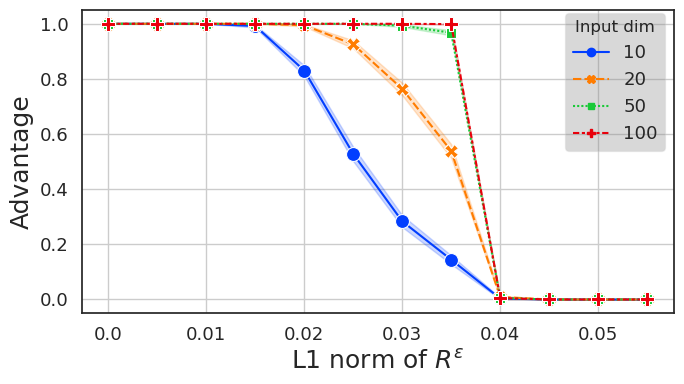

In [10]:
import seaborn as sns
from matplotlib.ticker import NullFormatter

def formatter(x, pos):
    return str(round(x, 2))

def formatter_y(x, pos):
    return str(round(x, 1))

plt.figure(figsize = (7,4))
sns.set(style='white',)
g = sns.lineplot( x="noise", y="Adv", 
                     data=adv_log, 
                     hue='dim',
                     style='dim',
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, markersize=10,
                     legend=True)

g.set(title ='')
g.set_xlabel(xlabel ="L1 norm of $R^\epsilon$", size = 18)
g.set_ylabel(ylabel ="Advantage", size = 18)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

plt.grid()

lgnd = g.legend(title='Input dim',
          bbox_to_anchor=(1.0, 1.02), fontsize=13, facecolor="gray", framealpha=0.3)


plt.tight_layout()
# plt.savefig('ldp_onehot.pdf')

In [ ]:
with open('adv_data_ldp_sphere.pkl', 'rb') as f:
    adv_log = pickle.load(f)

In [11]:
adv_log = pd.DataFrame()
runs = 800
N = 5
dim = range(10000, 40000, 5000)
beta_base = 10

noise_to_signal = [i/5000 for i in list(range(0,10,1))]

report_result = dict()

for r in range(runs):
    for noise_ratio in noise_to_signal:
        for d in dim:
            sentence = gen_sphere(N = N, dim = d)
            noise = gen_sphere(N = N, dim = d)
            noise = noise*noise_ratio
            beta = beta_base
            
            sentence_protected = sentence + noise
            delta = get_delta(sentence_protected)
            M = get_data_max_norm(sentence_protected)
            
            threshold = 1/(N*M*beta)
            prob_proj = get_proj_prob(sentence_protected, threshold)[0]
            lower_cond = get_delta_lower_cond(gen_sphere(N = N, dim = d) +  gen_sphere(N = N, dim = d)*noise_ratio, beta = beta, chunk = 1)
            delta_b = delta_bar(M, N, beta, delta)
            prob_box = get_prob_box(sentence, delta_b*3 + 0.5*beta*N*M*M*M*noise_ratio)
            adv = max(prob_proj + prob_proj**(2*N) -prob_box - 1, 0)

            report_result = {'dim': d,
                             'data': 'sphere',
                             'delta': delta,
                             'low': lower_cond,
                             'p_proj': prob_proj,
                              'length': N,
                              'prob_box': prob_box,
                             'noise': noise_ratio,
                              'Adv' :  adv}

            adv_log = pd.concat([adv_log, pd.DataFrame.from_records([report_result])])




In [12]:
# with open('adv_data_ldp_sphere.pkl', 'rb') as f:
#     adv_log = pickle.load(f)

/scratch/local/63940636/ipykernel_129932/1124131788.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/63940636/ipykernel_129932/1124131788.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


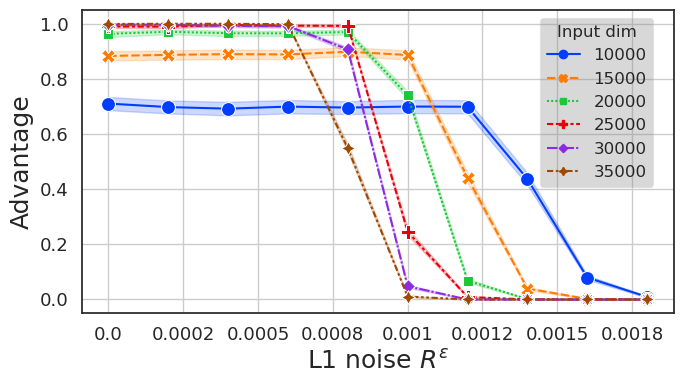

In [13]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper")

def formatter(x, pos):
    return str(round(x, 4))

def formatter_y(x, pos):
    return str(round(x, 1))


plt.figure(figsize = (7,4))
sns.set(style='white',)
g = sns.lineplot( x="noise", y="Adv", 
                     data=adv_log, 
                     hue='dim',
                     style='dim',
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, markersize=10,
                     legend=True)

g.set(title ='')
g.set_xlabel(xlabel ="L1 noise $R^\epsilon$", size = 18)
g.set_ylabel(ylabel ="Advantage", size = 18)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

plt.grid()

lgnd = g.legend(title='Input dim',
          bbox_to_anchor=(0.76, 0.39), fontsize=12, facecolor="gray", framealpha=0.3)

plt.tight_layout()
plt.savefig('ldp_sphere.pdf')